  ##                                                                    1&1 Data Science - Data Challenge
  ### Titanic Survival prediction

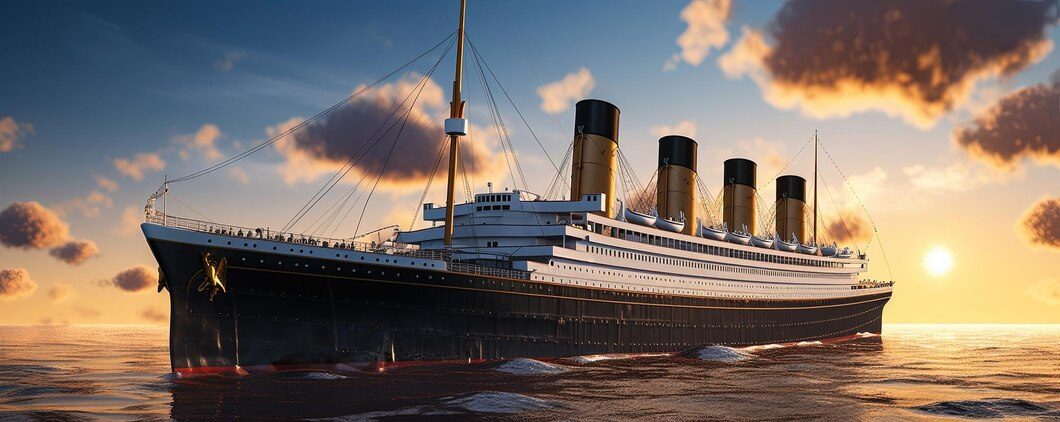

### The challenge:
###### The sinking of the Titanic is one of the most infamous shipwrecks in history. Using machine learning, create a model that predicts which passengers survived the Titanic shipwreck. Approach the challenge like a normal Data Science project.

## A. Introduction

Importing necessary libraries

In [606]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import shap

## B. Load datasets

The data has been split into two groups: <i>training set (train.csv)</i> and <i>test set (test.csv)</i>.
The <b>training set</b> is used to build the machine learning models. The training set contains the outcome (also known as the “ground truth”) for each passenger. 
The <b>test set</b> is used to see how well the model performs on unseen data. The test set does not contain the ground truth for each passenger.

In [607]:
#Load train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [608]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## C. Exploratory data analysis

### 1. Understanding data

In [609]:
# view dimensions of train dataset
print(train.shape)

(891, 12)


In [610]:
# view dimensions of test dataset
print(test.shape)

(418, 11)


In [611]:
# preview train dataset
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [612]:
# preview test dataset
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


We can see that train dataset has 891 rows and 12 columns, while test set has 418 rows and 11 columns. The reason why test set has one column less is because the <i>'Survived'</i> column ("ground truth") is not included in it. We want to predict this column.

In [613]:
# view summary of train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- We can see that the train dataset contains mixture of categorical and numerical variables.

- Categorical variables have data type <i>object</i>.

- Numerical variables have data type <i>int64</i> and <i>float64</i>.

- Also, there are some missing values in the 'Age', 'Cabin' and 'Embarked' columns.

###### For the next sections, we will use only train dataset.

### 2. Target variable analysis

We want to explore the "Survived" target variable.

In [614]:
# check for missing values
train['Survived'].isnull().sum()

0

In [615]:
# view unique values
train['Survived'].unique()

array([0, 1], dtype=int64)

In [616]:
# view the frequency distribution of values
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [617]:
# view the percentage of frequency distribution of values
train['Survived'].value_counts() / len(train) * 100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

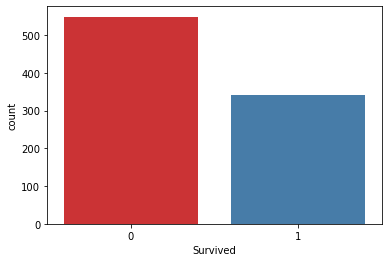

In [618]:
# visualize frequency distribution of target variable
f, ax = plt.subplots(figsize = (6, 4))
ax = sns.countplot(x = 'Survived', data = train, palette = "Set1")
plt.show()

- We can see that the 'Survived' column does not have null values
- The target variable contains two values (1 and 0), corresponding to the fact that a passenger has survived or not
- There are 549 passengers (61.61%) that did not survive and 342 that survived (38.38%), which means that the dataset is balanced

### 3. Features analysis

In this section, we will investigate all the features of the dataset, excepting the target variable.

In [619]:
print(train.columns.to_list())

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


##### 3.1. Missing values

In [620]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Check what features have missing values using a suitable plot.

<AxesSubplot:>

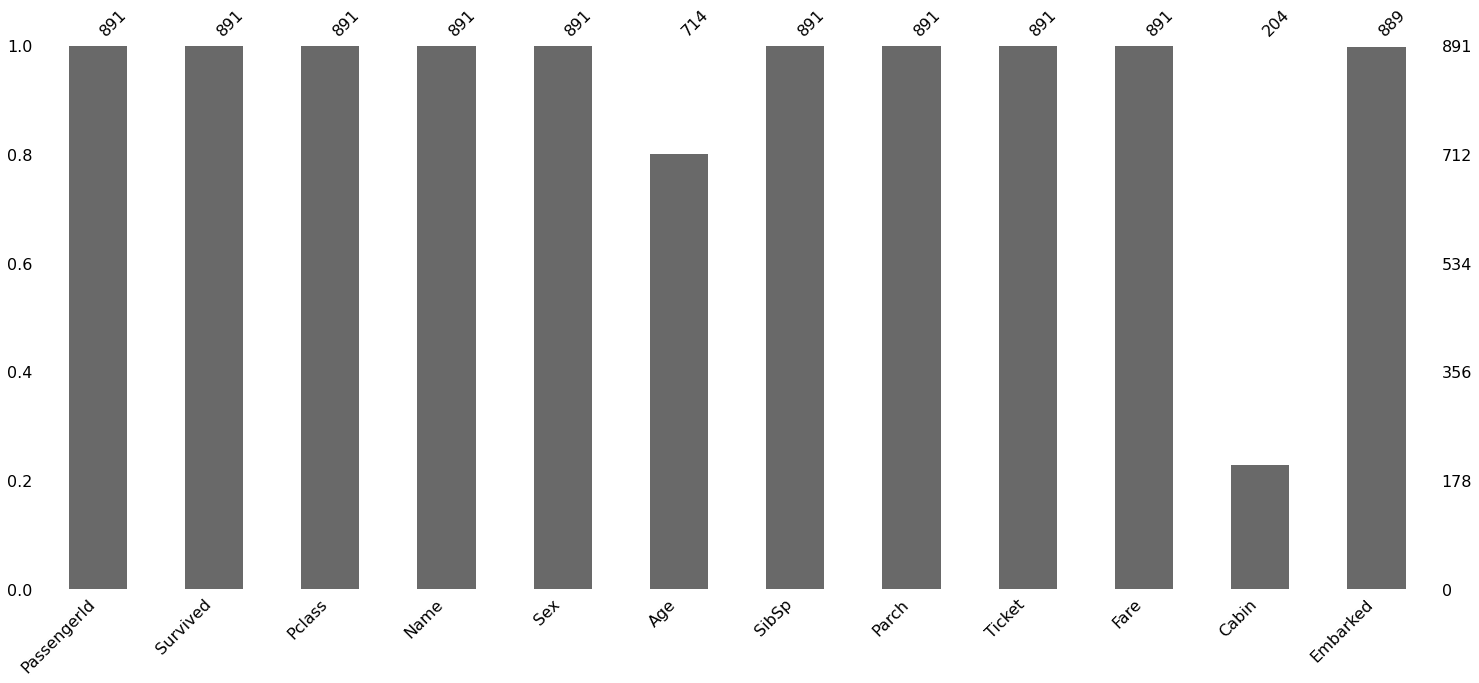

In [621]:
msno.bar(train[train.columns])

From the plot above, we can see that "Age" and "Cabin" features have an important part of missing values. Also, the "Embarked" column has only 2 missing values.

<b> Because we have a relatively small number of columns in the dataset,  we can explore each feature at a time.</b>
    
 <i> Note: The "PassengerId" column is not a feature that describe a passenger, but a way to identify a passenger. Therefore, this column will not be analyzed and, also, it will not help in the modelling part.</i>

### - Categorical features

##### 3.2. Pclass

As we know from the prerequisites of the challenge, the <b><i>Pclass</i></b> column represents a proxy for socio-economic status (SES) of each passenger (<i>1 = Upper, 2 = Middle, 3 = Lower</i>).

Although it has numerical values, this feature is categorical.

In [622]:
# view the distribution of each class
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

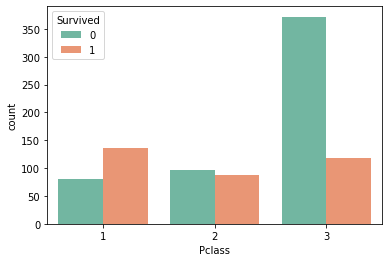

In [623]:
# visualize which passengers survived or not using a suitable plot
f, ax = plt.subplots(figsize = (6, 4))
ax = sns.countplot(data = train, x = 'Pclass', hue = 'Survived', palette = 'Set2')
plt.show()

In [624]:
print(round(train['Survived'].groupby(train['Pclass']).mean()  * 100, 2))

Pclass
1    62.96
2    47.28
3    24.24
Name: Survived, dtype: float64


We can see that passengers in first class have a higher chance of survival.

###### 3.3. Name

In [625]:
train['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

At the first glance, the <i>'Name'</i> feature might not help us, because it have a different value for every passenger, and therefore, the predictive model might not differentiate between passenger that survived or not based on their name.

But, we can see that passengers have the title in their name (Mr., Mrs., Miss. etc.).

In [626]:
# Get passenger titles
train["Title"] = train['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [627]:
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Mme               1
Ms                1
the Countess      1
Jonkheer          1
Sir               1
Lady              1
Don               1
Capt              1
Name: Title, dtype: int64

In [628]:
# grouping the rare titles into a single category (Rare)
train['Title'] = np.where(train['Title'].isin(['Dr', 'Rev', 'Major', 'Col', 'Mlle', 'Mme', 'Ms', 'the Countess', 'Jonkheer', 'Sir', 'Lady', 'Don', 'Capt']), 'Rare', train['Title'])

In [629]:
print(round(train['Survived'].groupby(train['Title']).mean().sort_values(ascending = False)  * 100, 2))

Title
Mrs       79.20
Miss      69.78
Master    57.50
Rare      44.44
Mr        15.67
Name: Survived, dtype: float64


We can see that there is a relationship between passenger title and their survival chances.

In the <b> Feature engineering </b> part, we can reencode this feature by including <i> 'Dr', 'Rev', 'Major', 'Col', 'Mlle', 'Mme', 'Ms', 'the Countess', 'Jonkheer', 'Sir', 'Lady', 'Don', 'Capt' </i> in the <b> Rare </b> category.

###### 3.4. Sex

In [630]:
# view the distribution of each class of 'Sex' feature
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

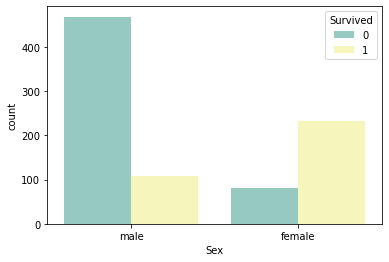

In [631]:
# visualize which passengers survived or not using a suitable plot
f, ax = plt.subplots(figsize = (6, 4))
ax = sns.countplot(data = train, x = 'Sex', hue = 'Survived', palette = 'Set3')
plt.show()

We can see that there is a relationship between passenger sex and their chances of survival.

In the <b> Feature engineering </b> part, for an easier use of algorithms, we can reencode this feature's classes into numerical values.

###### 3.5. Ticket

In [632]:
train['Ticket'].head(20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

We can see that the 'Ticket' feature has both numerical and categorical values and does not follow a visible pattern. We can remove this feature.

###### 3.6. Cabin

In [633]:
# check missing values
train['Cabin'].isnull().sum()

687

In [634]:
#check unique values for this feature
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

We can see that each cabin begins with a letter, maybe related to a category where it belongs. A cabin category feature could help. 

In [635]:
# Get the category of cabins
train["cabin_category"] = train["Cabin"].apply(lambda x: str(x)[0])

# Print value counts of first letters
print(train["cabin_category"].value_counts())


n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_category, dtype: int64


In [636]:
# Surviving rate of Cabin first letters
print(train.groupby("cabin_category")["Survived"].mean().sort_values(ascending = False))

cabin_category
D    0.757576
E    0.750000
B    0.744681
F    0.615385
C    0.593220
G    0.500000
A    0.466667
n    0.299854
T    0.000000
Name: Survived, dtype: float64


We can see that the passengers in some cabin categories have more chances to survive than those in other categories. But, in the same time, we have a lot of missing values for this feature. Dropping this feature might help in the modelling part.

###### 3.7. Embarked

This feature shows us the port of embarking.

In [637]:
# view the distribution of each class
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

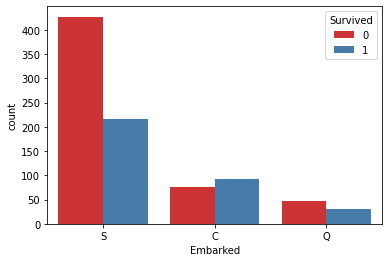

In [638]:
# visualize which passengers survived or not using a suitable plot
f, ax = plt.subplots(figsize = (6, 4))
ax = sns.countplot(data = train, x = 'Embarked', hue = 'Survived', palette = 'Set1')
plt.show()

In [639]:
print(round(train['Survived'].groupby(train['Embarked']).mean()  * 100, 2))

Embarked
C    55.36
Q    38.96
S    33.70
Name: Survived, dtype: float64


We can see that passengers embarked in C (Cherbourg) have higher chances of survival.



### - Numerical features

###### 3.8. Correlations

In [640]:
numerical_features = [col for col in train.columns if train[col].dtype != 'object' and col not in ['Pclass', 'PassengerId']]
print(numerical_features)

['Survived', 'Age', 'SibSp', 'Parch', 'Fare']


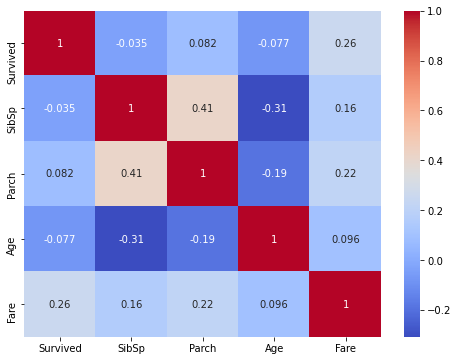

In [641]:
f, ax = plt.subplots(figsize = (8, 6))
ax = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True,  cmap = "coolwarm")
plt.show()

Although the correlation coefficients are not high, subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features.

###### 3.9. Age

In [642]:
# checking for missing values
train['Age'].isnull().sum()

177

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


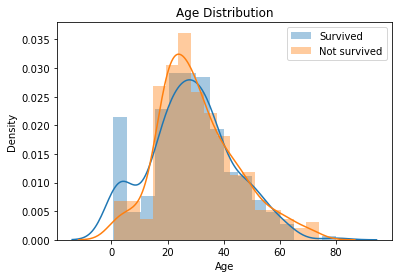

In [643]:
# Distribution of passengers by age and surving or not

# Survived by age
sns.distplot(train[train['Survived'] == 1]['Age'], label = "Survived")

# Not survived by age
sns.distplot(train[train['Survived'] == 0]['Age'], label = "Not survived")

plt.legend()
plt.title("Age Distribution")
plt.show()

We can see that the distribution of age is normal. Also, it seems that younger passengers have survived less.

###### 3.10. SibSp and Parch

This two features are related to family.

In [644]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

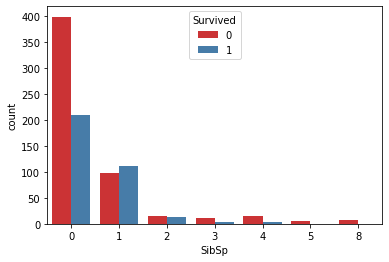

In [645]:
# visualize which passengers survived or not using a suitable plot
f, ax = plt.subplots(figsize = (6, 4))
ax = sns.countplot(data = train, x = 'SibSp', hue = 'Survived', palette = 'Set1')
plt.show()

In [646]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

<AxesSubplot:xlabel='Parch', ylabel='count'>

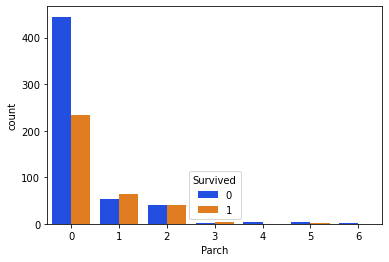

In [647]:
# visualize which passengers survived or not using a suitable plot
sns.countplot(data = train, x = 'Parch', hue = 'Survived', palette = 'bright')

We can see that the number of passengers that were alone on the ship is higher that the number of passenger that went with a member of family. It also looking like there is a relationship between family and chances of survival.

Also, because these two features are related to family, they can be combined.

###### 3.11. Fare

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


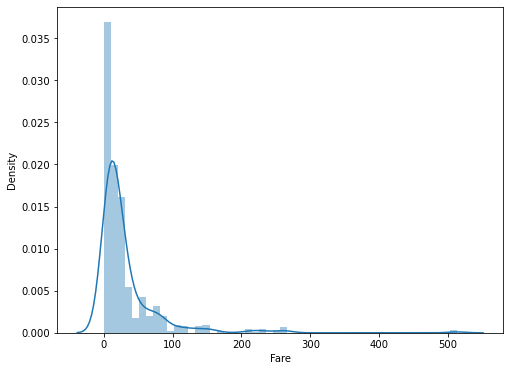

In [648]:
# Plot the histogram
f, ax = plt.subplots(figsize = (8, 6))
ax = sns.distplot(train["Fare"])
plt.show()

We can see that the distribution is skewed, with the majority of values being low.

## D. Feature engineering

### 1. Missing values imputation

Importing both train and test datasets.

In [649]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [650]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [651]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


###### 1.1. Age

For the 'Age' feature, there may be many imputation strategies. One strategy can be the arbitrary value imputation (mean or median of all population). We will use median imputation.

In [652]:
train['Age'] = train['Age'].fillna(train['Age'].median())

In [653]:
# imputing missing values on test set using train median
test['Age'] = test['Age'].fillna(train['Age'].median())

###### 1.2. Cabin

In [654]:
print(train['Cabin'].isnull().sum())
print(test['Cabin'].isnull().sum())

687
327


Because there are a lot of missing values in both train and test sets, we better drop this feature.

In [655]:
train = train.drop(columns = ['Cabin'])
test = test.drop(columns = ['Cabin'])

###### 1.3. Embarked

For this feature, we will use most frequent class imputation.

In [656]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [657]:
train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')

Check if there are other features with missing values

In [658]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [659]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64

In [660]:
# imputing missing value in Fare column of test dataset with median
test['Fare'] = test['Fare'].fillna(train['Fare'].median())

### 2. Features transformation

In feature analysis step, we decided to transform some of the features.

###### 2.1. Name

train

In [661]:
# Get passenger titles
train["Title"] = train['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

# grouping the rare titles into a single category (Rare)
train['Title'] = np.where(train['Title'].isin(['Dr', 'Rev', 'Major', 'Col', 'Mlle', 'Mme', 'Ms', 'the Countess', 'Jonkheer', 'Sir', 'Lady', 'Don', 'Capt']), 'Rare', train['Title'])

In [662]:
# Get passenger titles
test["Title"] = test['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

# grouping the rare titles into a single category (Rare)
test['Title'] = np.where(test['Title'].isin(['Dr', 'Rev', 'Major', 'Col', 'Mlle', 'Mme', 'Ms', 'the Countess', 'Jonkheer', 'Sir', 'Lady', 'Don', 'Capt']), 'Rare', test['Title'])

Drop 'Name' feature

In [663]:
train = train.drop(columns = ['Name'])
test = test.drop(columns = ['Name'])

In [664]:
test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,male,34.5,0,0,330911,7.8292,Q,Mr
1,893,3,female,47.0,1,0,363272,7.0000,S,Mrs
2,894,2,male,62.0,0,0,240276,9.6875,Q,Mr
3,895,3,male,27.0,0,0,315154,8.6625,S,Mr
4,896,3,female,22.0,1,1,3101298,12.2875,S,Mrs
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,male,28.0,0,0,A.5. 3236,8.0500,S,Mr
414,1306,1,female,39.0,0,0,PC 17758,108.9000,C,Dona
415,1307,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,Mr
416,1308,3,male,28.0,0,0,359309,8.0500,S,Mr


###### 2.2. Sex

Transform values of this feature in numerical values.

In [665]:
train['Sex'] = train['Sex'].map({'male' : 0, 'female' : 1})
test['Sex'] = test['Sex'].map({'male' : 0, 'female' : 1})

###### 2.3. Combine SibSp and Parch into a single feature

In [666]:
# Create family size feature

In [667]:
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']

###### 2.4. Drop unnecessary features

We conclude in the previous step that 'PassengerId' and 'Ticket' features to be dropped. Also, 'SibSp' and 'Parch' will be dropped.

In [668]:
train = train.drop(columns = ['PassengerId', 'Ticket', 'SibSp', 'Parch'])
test = test.drop(columns = ['PassengerId', 'Ticket', 'SibSp', 'Parch'])

In [669]:
test

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,3,0,34.5,7.8292,Q,Mr,0
1,3,1,47.0,7.0000,S,Mrs,1
2,2,0,62.0,9.6875,Q,Mr,0
3,3,0,27.0,8.6625,S,Mr,0
4,3,1,22.0,12.2875,S,Mrs,2
...,...,...,...,...,...,...,...
413,3,0,28.0,8.0500,S,Mr,0
414,1,1,39.0,108.9000,C,Dona,0
415,3,0,38.5,7.2500,S,Mr,0
416,3,0,28.0,8.0500,S,Mr,0


### 3. Categorical encoding

In [670]:
categorical = ['Pclass', 'Embarked', 'Title']

For categorical encoding we will use One Hot Encoder.

In [671]:
print("Object Columns for One-Hot Encoding: ", categorical)

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train[categorical]), columns = OH_encoder.get_feature_names(categorical))
OH_cols_test = pd.DataFrame(OH_encoder.transform(test[categorical]), columns = OH_encoder.get_feature_names(categorical))

Object Columns for One-Hot Encoding:  ['Pclass', 'Embarked', 'Title']


In [672]:
train = pd.concat([train, OH_cols_train], axis = 1)
test = pd.concat([test, OH_cols_test], axis = 1)

In [673]:
train = train.drop(columns = ['Pclass', 'Embarked', 'Title'])
test = test.drop(columns = ['Pclass', 'Embarked', 'Title'])

## E. Model development

###### 1. Select independent variables and target variable separately. 

In [674]:
#indepent variables
X = train.drop(columns = ['Survived'])

#target variable
y = train['Survived']

###### 2. Split train set in X_train, X_test, y_train, y_test

In [675]:
from sklearn.model_selection import train_test_split

# Split the data info training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 123)

###### 3. Random Forest

In [676]:
# instatiate algorithm
rf = RandomForestClassifier(n_estimators = 300, max_depth = 5, n_jobs = -1, random_state = 123)

In [677]:
# train algorithm
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=300, n_jobs=-1,
                       random_state=123)

In [678]:
# predict results
y_predict = rf.predict(X_test)

<b> Metrics </b>

In [679]:
# Accuracy
accuracy = accuracy_score(y_test, y_predict)

In [680]:
print('Accuracy score for Random Forest Classifier is: ', accuracy)

Accuracy score for Random Forest Classifier is:  0.8555555555555555


In [681]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[55  7]
 [ 6 22]]


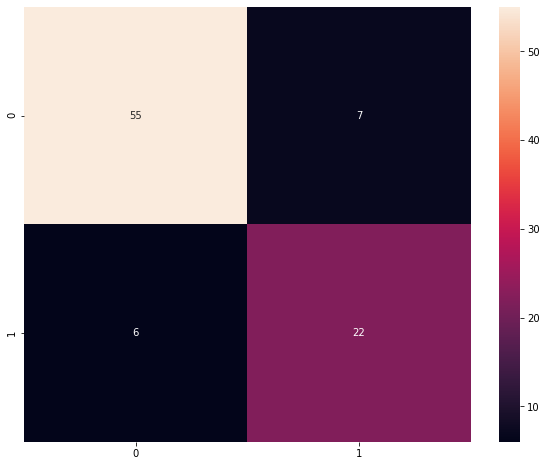

In [682]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.show()

In [683]:
# precission, recall
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
print('Precision score:', precision)
print('Recall score: ', recall)

Precision score: 0.7586206896551724
Recall score:  0.7857142857142857


In [684]:
# auc score
auc_score = roc_auc_score(y_test, y_predict)
print("AUC score is: ", auc_score)

AUC score is:  0.8364055299539169


###### 4. LightGBM

In [685]:
# instatiate algorithm
lgb = LGBMClassifier(n_estimators = 300, max_depth = 5, n_jobs = -1, random_state = 123)

In [686]:
# train algorithm
lgb.fit(X_train, y_train)

LGBMClassifier(max_depth=5, n_estimators=300, random_state=123)

In [687]:
# predict results
y_predict = lgb.predict(X_test)

<b> Metrics </b>

In [688]:
# Accuracy
accuracy = accuracy_score(y_test, y_predict)

In [689]:
print('Accuracy score for LightGBM Classifier is: ', accuracy)

Accuracy score for LightGBM Classifier is:  0.8666666666666667


In [690]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[56  6]
 [ 6 22]]


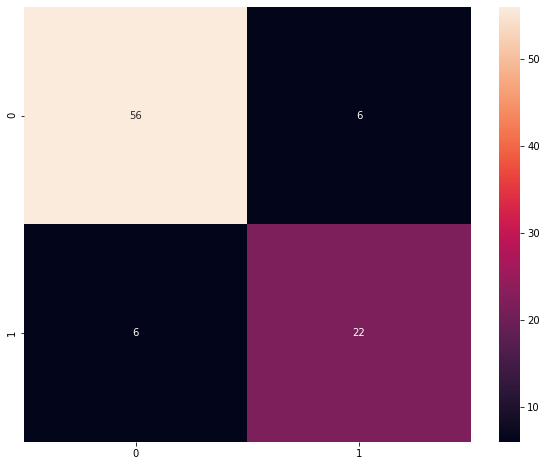

In [691]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.show()

In [692]:
# precission, recall
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
print('Precision score:', precision)
print('Recall score: ', recall)

Precision score: 0.7857142857142857
Recall score:  0.7857142857142857


In [693]:
# auc score
auc_score = roc_auc_score(y_test, y_predict)
print("AUC score is: ", auc_score)

AUC score is:  0.8444700460829493


###### 5. XGBoost

In [694]:
# instatiate algorithm
xgb = XGBClassifier(n_estimators = 200, max_depth = 5, n_jobs = -1, random_state = 123)

In [695]:
# train algorithm
xgb.fit(X_train, y_train)

[09:58:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [696]:
# predict results
y_predict = xgb.predict(X_test)

<b> Metrics </b>

In [697]:
# Accuracy
accuracy = accuracy_score(y_test, y_predict)

In [698]:
print('Accuracy score for XGB Classifier is: ', accuracy)

Accuracy score for XGB Classifier is:  0.8555555555555555


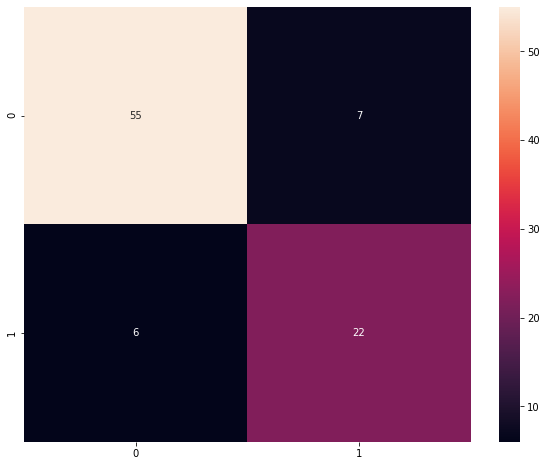

In [699]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.show()

In [700]:
# precission, recall
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
print('Precision score:', precision)
print('Recall score: ', recall)

Precision score: 0.7586206896551724
Recall score:  0.7857142857142857


In [701]:
# auc score
auc_score = roc_auc_score(y_test, y_predict)
print("AUC score is: ", auc_score)

AUC score is:  0.8364055299539169


<b> Comment: </b>

By testing three algorithms (Random Forest, LightGBM, XGBoost), we saw that the best performance on a baseline model was obtained by LightGBM. Next, we will perform hyperparameter tuning of this algorithm.

###### 6. LightGBM hyperparameter tuning

In [702]:
# declare possible values of hyperparameters

params = {'n_estimators': [100, 200, 300, 350],
          'max_depth': [4,5,7,8],
          'min_samples_leaf' : [3, 4],
          'min_samples_split': [3, 5, 10],
          'max_leaf_nodes':[2,3],
            }

In [703]:
lgb = LGBMClassifier(random_state = 123, importance_type = 'gain')

In [704]:
clf = GridSearchCV(estimator = lgb, param_grid = params, cv = 5, n_jobs = -1) 

In [705]:
clf.fit(X_train, y_train.ravel())

print(clf.best_estimator_)
print(clf.best_score_)

lgb_best = clf.best_estimator_

# Predict from the test set
y_pred = clf.predict(X_test)

# Print the accuracy with accuracy_score function
print("Accuracy: ", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix\n")
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=2 will be ignored. Current value: num_leaves=31
LGBMClassifier(importance_type='gain', max_depth=4, max_leaf_nodes=2,
               min_samples_leaf=3, min_samples_split=3, random_state=123)
0.8326940993788821
Accuracy:  0.8777777777777778

Confusion Matrix

[[57  5]
 [ 6 22]]


## F. Model explainability

##### 1. Feature importance

In [706]:
importance = pd.DataFrame({'Value':lgb_best.feature_importances_,'Feature':X.columns})

importance = importance.sort_values(by = ['Value'], ascending = False)

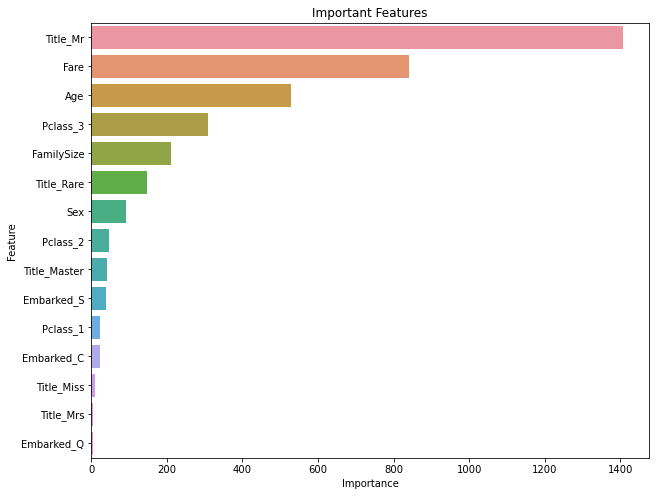

In [708]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.barplot(x = importance.Value, y = importance.Feature)
# Add labels to your graph
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title("Important Features")
plt.show()

We can see that the most important features are: Title_Mr, Fare, Age, Pclass_3, FamilySize.

###### 2. Shap

In [709]:
explainer = shap.TreeExplainer(lgb_best)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [710]:
shap_values[1]

array([[ 0.11232269,  0.50841687, -0.25533733, ...,  1.42657463,
        -0.00429712,  0.04756915],
       [-0.222333  , -0.25504984, -1.19031269, ..., -1.21952964,
        -0.01054255,  0.03501008],
       [-0.35870098, -0.02026314,  0.69074778, ..., -1.32296247,
        -0.00698384,  0.06373494],
       ...,
       [-0.11390687, -0.2740018 , -0.26168351, ..., -0.94671475,
        -0.00685895,  0.0343515 ],
       [-0.36175082, -0.04590898,  0.57526732, ..., -1.24337062,
        -0.00685895,  0.05604579],
       [-0.15253666,  1.33252006, -0.42922475, ..., -0.97429043,
        -0.00865509,  0.03511986]])

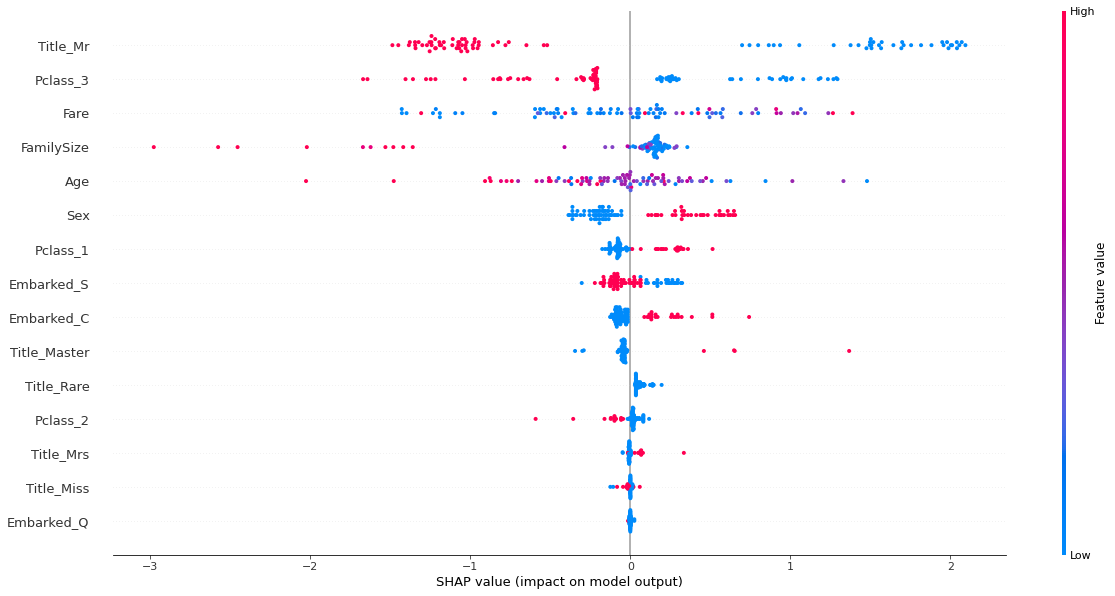

In [711]:
shap.summary_plot(shap_values[1], X_test, plot_size = (20, 10))

- By looking at the shap plot, we can see how the feature are influencing the prediction.
- Blue color shows low values of feature, while red color shows high values of features. Also, points found in the left of vertical line at 0 shows a lower probability for that observations to survive, while points found at right shows a higher probability to survive.
- Therefore, passenger that have not ‘Mr.’ title (Title_Mr = 0) are more likely to survive.
- Passenger that are not found in ticket class 3 (Pclass_3 = 0) are more likely to survive.
- Passengers with a high number of family members have low chances to survive.


## G. Submission

Train the best model on entire train dataset

In [712]:
best_clf = LGBMClassifier(n_estimators = 100, max_depth = 4, max_leaf_nodes = 2, min_samples_leaf = 3, min_samples_split = 3, random_state = 123)

train_data = train.drop(columns = ['Survived'])

best_clf.fit(train_data, train['Survived'])

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=2 will be ignored. Current value: num_leaves=31


LGBMClassifier(max_depth=4, max_leaf_nodes=2, min_samples_leaf=3,
               min_samples_split=3, random_state=123)

In [713]:
# Store passenger ids
ids = pd.read_csv("test.csv")[["PassengerId"]].values

# Make predictions
predictions = best_clf.predict(test.values)

# Create a dictionary with passenger ids and predictions
df = {'PassengerId': ids.ravel(), 'Survived':predictions}

# Create a DataFrame named submission
submission = pd.DataFrame(df)

# Display the first five rows of submission
display(submission.head())

# Save the file
submission.to_csv("submission.csv", index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
